# Develop and evaluate neural network models using Keras for a regression problem

__Author - Sarthak Kaushik__

__Date - October 11, 2021__

Objectives are to demonstrate: 
- How to create a neural network model with Keras for a regression problem
- How to use scikit-learn with Keras to evaluate models using Mean Squared Error (MSE) 
- How to tune the network topology of models with Keras

## Describe and identify important hyperparameters  

### *Note* 
- Use MSE (Mean Squared Error) as the score/loss function that will be minimized for hyperparameter optimization 

## Description of data being used in this assignment
Although the purpose of this assignment is only to construct Keras models and conduct hyperparameter tuning, however if interested, you can see some information about the data in the section below:

- In this assignment, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. 

- The dataset for this project originates from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

*Variables include:*
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town.
- CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10,000 dollars
- PTRATIO: pupil-teacher ratio by town
- B: Proportion of African Americans by town
- LSTAT: Percent lower status of the population
- MEDV: Median value of owner-occupied homes in  1000’s dollars (i.e. the outcome variable) 

from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
df['MEDV'] = boston_dataset.target
df.head(n=5)

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import math

chart_studio.tools.set_credentials_file(username='DemoAccount', api_key='lr1c37zw81')


total_items = len(df.columns)
items_per_row = 3
total_rows = math.ceil(total_items / items_per_row)
fig = make_subplots(rows=total_rows, cols=items_per_row)
cur_row = 1
cur_col = 1
for index, column in enumerate(df.columns):
    fig.add_trace(go.Box(y=df[column], name=column), row=cur_row, col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    
fig.update_layout(height=1000, width=550,  showlegend=False)
#fig.show()
plotly.offline.iplot(fig, filename='jupyter-styled_bar')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import numpy as np

total_items = len(df.columns)
items_per_row = 3
total_rows = math.ceil(total_items / items_per_row)
fig = make_subplots(rows=total_rows, cols=items_per_row, subplot_titles=df.columns)
cur_row = 1
cur_col = 1
for index, column in enumerate(df.columns):
    fig.add_trace(go.Scattergl(x=df[column], 
                            y=df['MEDV'], 
                            mode="markers", 
                            marker=dict(size=3)), 
                  row=cur_row, 
                  col=cur_col)
    
    intercept = np.poly1d(np.polyfit(df[column], df['MEDV'], 1))(np.unique(df[column]))
    
    fig.add_trace(go.Scatter(x=np.unique(df[column]), 
                             y=intercept, 
                             line=dict(color='red', width=1)), 
                  row=cur_row, 
                  col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    
fig.update_layout(height=1000, width=550, showlegend=False)
fig.show()

In [1]:
import numpy as np
np.random.seed(10)

import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow messaging set using the AUTOGRAPH_VERBOSITY environment variable
#tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

import random
random.seed(10)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data import

In [3]:
from tensorflow.keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [4]:
def model_kfold_validation(model, x_tr, y_tr, x_te, y_te, verbose = 1, kfold = 5):
    # Training Model
    model = KerasRegressor(build_fn = base_model, 
                           nb_epoch = 100, 
                           batch_size = 1024, 
                           verbose = verbose)

    #kfold cross validation
    folds = KFold(n_splits=kfold, shuffle = False)
    results = cross_val_score(model, x_tr, y_tr, cv=folds)
    print ("\033[1mResults on Train Data kFoldVaildation\033[0m")
    print("Model MSE: (%.2f) Mean, (%.2f) Stdev\n" % (results.mean(), results.std()))
    
    #plot crossvalidation results
    sns.barplot(x = np.arange(0,kfold), y = -results).set_title('Cross Validation Error')
    plt.show()

    # Model Fit
    model.fit(x_tr, y_tr, verbose = verbose)

    # Model Prediction
    prediction = model.predict(x_te)
    
    sns.scatterplot(x=y_te, y=prediction)
    plt.show()
    
    # PRINT DATA
    print ("\033[1mResults on Test Data kFoldVaildation\033[0m'")
    print("Model MSE on Test Data = %.2f" % mean_squared_error(y_te, prediction))
    print("Model MAE on Test Data = %.2f" % mean_absolute_error(y_te, prediction))
    print("Model MAPE, on Test Data = %.2f%%" % mean_absolute_percentage_error(y_te, prediction))
    
    return

# Part 1: Impact of change in model architecture: 
Compare 2 models with a baseline model

## Baseline model - Non Standardized Data
Develop a Baseline Neural Network Model using a simple model that has a single fully connected hidden layer with 13 neurons as input attributes

In [5]:
#Let's develop a Baseline Neural Network Model using a simple model that has:
#  a single fully connected hidden layer with the same number of neurons (i.e. 13) as input attributes
def base_model(n=1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'adam', gr_learning_rate = 0.01):

    model=keras.models.Sequential([
    # create model
        keras.layers.Dense(units = nodes, activation = activation, input_shape = (x_train.shape[1],)),
        keras.layers.Dense(units = 1 , activation="linear"),
        ]
        , name="Base_model",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate)
    
    # LOSS FUNCTION
    ## Taken as input to the functionbb
    
    #Model Compile
    model.compile(optimizer=optimizer, 
                  loss= loss, 
                  metrics = [tf.keras.metrics.MeanSquaredError()])

    return model

__kfold value of 20 is used to adhere to 5% validation set.__

2021-10-11 15:21:31.445315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-11 15:21:31.563935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Results on Train Data kFoldVaildation
Model MSE: (-16432.28) Mean, (41549.74) Stdev



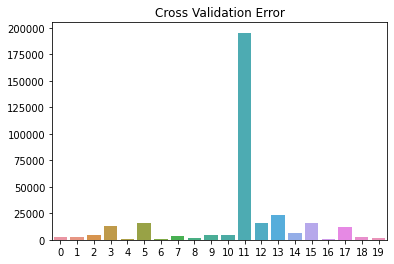

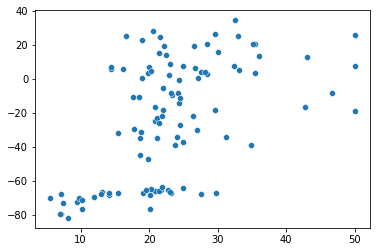

Results on Test Data kFoldVaildation'
Model MSE on Test Data = 3181.74
Model MAE on Test Data = 47.70
Model MAPE, on Test Data = 284.31%
CPU times: user 8.2 s, sys: 221 ms, total: 8.42 s
Wall time: 7.97 s


In [6]:
%%time
model_kfold_validation(base_model, x_train, y_train, x_test, y_test, verbose = 0, kfold = 20)

### Provide a short and clear description of the results 
For the cross validation mse __(Loss)__ for the base model, the standard deviation is observed to be quite large compared to the mean. This shows inconsistency of the model which is also shown from the plt of 20 cross validation . This shows that the model developed on raw data is not the correct model as it performs differently on the test data itself. 

The results of crossvalidation suggest that the model is either an underfit or overfit. This is also confirmed by an MAPE error of 745% on the test data.

## Baseline model - Standardizing data
Standardize the data and run the baseline model

In [7]:
# Standardize data
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

Results on Train Data kFoldVaildation
Model MSE: (-588.28) Mean, (173.34) Stdev



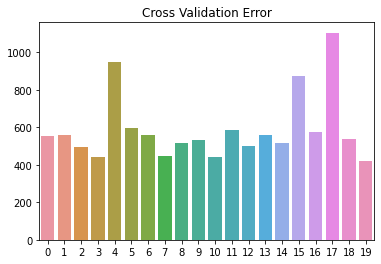

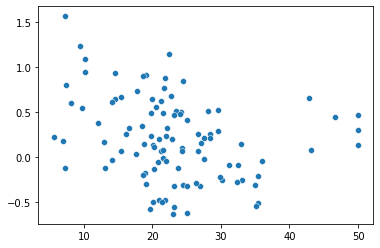

Results on Test Data kFoldVaildation'
Model MSE on Test Data = 609.37
Model MAE on Test Data = 22.88
Model MAPE, on Test Data = 98.52%
CPU times: user 7.6 s, sys: 175 ms, total: 7.78 s
Wall time: 7.32 s


In [8]:
%%time
# Model k Fold Validation
model_kfold_validation(base_model, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

### Provide a short and clear description of the results 
For the cross validation error for the base model with standardized data, the standard deviation is observed to be lower than the mean value. This is also shown from the plt of 20 cross validation. This shows that the model developed on standardized data will appropriately models on test data. 

This is also suggested by an error of 100% on the test data which is significantly better than what was reported on the non-standardized data. However, this is still not the best and a different netowrk topography is required to get a better fitting model.

As such, the rest of the analysis is done on standardized data.

## Deeper Network 

In [9]:
# construct and evaluate a model with 2 dense layers with smaller number of neurons (e.g. 16, 8)  
def deep_model(n=1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'adam', gr_learning_rate = 0.01):

    model=keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 16, activation = activation, input_shape = (x_train.shape[1],)),
        keras.layers.Dense(units = 8, activation= activation),
        keras.layers.Dense(units = 1 , activation="linear"),
        ]
        , name="deep_model",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate) 
    
    # LOSS FUNCTION
    ## Taken as input to the functionbb
    
    #Model Compile
    model.compile(optimizer=optimizer, 
                  loss= loss, 
                  metrics = [tf.keras.metrics.MeanSquaredError()])

    return model

Results on Train Data kFoldVaildation
Model MSE: (-594.86) Mean, (163.16) Stdev



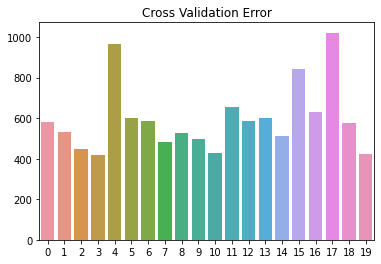

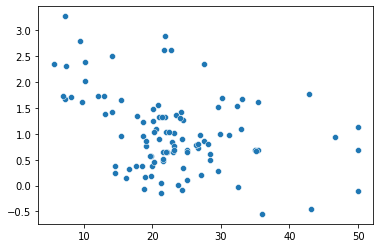

Results on Test Data kFoldVaildation'
Model MSE on Test Data = 575.32
Model MAE on Test Data = 22.06
Model MAPE, on Test Data = 93.58%


In [10]:
# Model k Fold Validation
#using standardized data as discussed in the baseline model above
model_kfold_validation(deep_model, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

### Provide a short and clear description of the results
As observed from the observations above, 2 dense layers with smaller number of neurons (e.g. 16, 8) is not too better than a base model considering the various test evaluation metrics. The MAPE for deeper model is marginally lower than the baseline model (standardized data). 
Therefore, this is not a significant improvement over the baseline model.

## Wider Network 

In [11]:
# construct and evaluate a wider model with more neurons (e.g. 32, 16)
def wide_model(n=1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'adam', gr_learning_rate = 0.01):

    model=keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 32, activation = activation, input_shape = (x_train.shape[1],)),
        keras.layers.Dense(units = 16, activation= activation),
        keras.layers.Dense(units = 1 , activation="linear"),
        ]
        , name="wide_model",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate) 
    
    # LOSS FUNCTION
    ## Taken as input to the functionbb
    
    #Model Compile
    model.compile(optimizer=optimizer, 
                  loss= loss, 
                  metrics = [tf.keras.metrics.MeanSquaredError()])

    return model

Results on Train Data kFoldVaildation
Model MSE: (-586.38) Mean, (174.75) Stdev



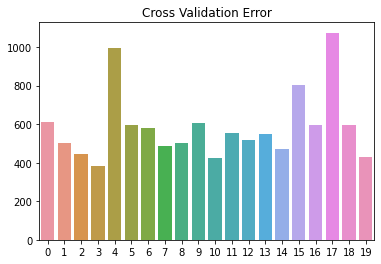

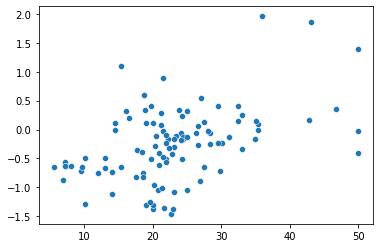

Results on Test Data kFoldVaildation'
Model MSE on Test Data = 623.20
Model MAE on Test Data = 23.34
Model MAPE, on Test Data = 101.97%


In [12]:
# Model k Fold Validation
model_kfold_validation(wide_model, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

### Provide a short and clear description of the results
As observed from the observations above, 2 dense layers with larger number of neurons (e.g. 32, 16) is not too better than a base model when considering the various test evaluation metrics. The MAPE for deeper model is marginally lower than the baseline model (standardized data). 
Therefore, this is also not a significant improvement over the baseline model.

# Part 2: Hyperparameter optimization experiments 
Use a combination of hyperparameters, evaluate and visualize the results and compare the models

__Used standardized data for these models.__

In [13]:
def model_loss(model, params, x_tr, y_tr, verbose = 1):
        
    # Model EVALUATION ON TEST DATA
    # prediction = model_eval(grid_result_base, x_te, y_te)
    history = model (params).fit(x_tr, y_tr, validation_split=0.05, batch_size=1024, epochs=100, verbose = verbose)
    
    #plot loss
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return None

def model_grid_searchcv (model, param_grid, X, y, x_te, y_te, verbose = 1, kfold = 20): 
    
    # KERAS REGRESSOR MODEL
    bmodel = KerasRegressor(build_fn = model, 
                           nb_epoch = 100, 
                           batch_size = 1024, 
                           verbose = verbose)

    # SCIKIT LEARN GRID SEARCH &. CROSS VALIDATION
    grid = GridSearchCV(estimator = bmodel, 
                        param_grid = param_grid,  
                        cv = kfold,
                        n_jobs = 1)
    
    #TRAIN Data on all parameters
    grid_result_base = grid.fit(X, y)

    # Plotting Data for GridSearch CV
    cols = ['param_dropoutRate','param_gr_learning_rate', 'param_l2','mean_test_score',
           'std_test_score', 'rank_test_score']
    results_filt = pd.DataFrame(grid_result_base.cv_results_)[cols]
    
    results_filt.plot.line(subplots=True, figsize=(12,12))
    plt.show()

    # PRINT DATA
    print ("\033[1mResults on GridSeachCV\033[0m")
    print ("Training: \nThe best model score is : %.2f \nThe best model parameters are: %s "
           % (grid_result_base.best_score_, grid_result_base.best_params_))
    
    model_loss(model,grid_result_base.best_params_, X, y, verbose = verbose)
    
    # Model EVALUATION ON TEST DATA
    # prediction = model_eval(grid_result_base, x_te, y_te)
    prediction = grid_result_base.predict(x_te)
    
    # Model EVALUATION ON TEST DATA
    print ("\033[1mResults on Test Data\033[0m")
    print("Model MSE on Test Data = %.2f" % mean_squared_error(y_te, prediction))
    print("Model MAE on Test Data = %.2f" % mean_absolute_error(y_te, prediction))
    print("Model MAE_pct, on Test Data = %.2f%%" % mean_absolute_percentage_error(y_te, prediction))
    
    return None


In [14]:
# PARAMETERS DEFINED FOR Hyperparameter Optimization Experiments

gr_learning_rate = [0.001, 0.01, 0.1]
dropoutRate = [0, 0.1, 0.2, 0.3]
l2 = [0.001, 0.01, 0.1]

# CREATE PARAMETER GRID
param_grid = dict(gr_learning_rate = gr_learning_rate, l2 = l2, dropoutRate = dropoutRate)

## Model 1: 
- 2 Dense layers
- The first with 64 neurons using a ReLU activation function
- the second with 64 neurons using a ReLU activation function
- Choose an appropriate output layer and activation
- train model with 100 epochs and use 5% of samples as validation set
- Plot both loss and mean average error
- Conduct model evaluation tests

In [15]:
def model_1 (n = 1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'sgd', gr_learning_rate = 0.01, dropoutRate = 0 , l2 = 0.01): 
    model=keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 64, activation = activation, input_shape = (x_train_st.shape[1],),kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 64, activation= activation, kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 1 , activation="linear", kernel_regularizer = keras.regularizers.l2(l2)),
        ]
        , name="model_1",)

    #print(model.summary())
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate)  
    elif optimizer.lower() == 'rmsprop':
        optimizer=keras.optimizers.RMSprop(learning_rate=gr_learning_rate)    
    
    # Compile Model
    model.compile(optimizer= optimizer, 
                  loss= 'mean_squared_error', 
                  metrics = [tf.keras.metrics.MeanSquaredError()])
    
    return model

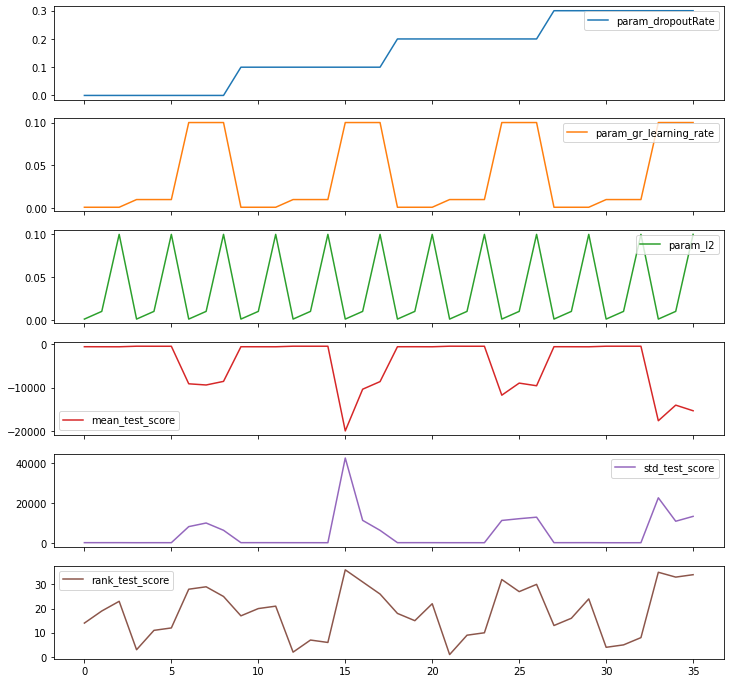

Results on GridSeachCV
Training: 
The best model score is : -448.18 
The best model parameters are: {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.001} 


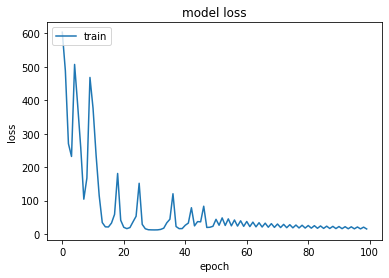

Results on Test Data
Model MSE on Test Data = 486.57
Model MAE on Test Data = 20.30
Model MAE_pct, on Test Data = 86.37%
CPU times: user 5min 13s, sys: 4.79 s, total: 5min 18s
Wall time: 5min 14s


In [16]:
%%time
model_grid_searchcv (model_1, param_grid, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

## Model 2
2 Dense layers
- The first with 128 neurons using a ReLU activation function
- the second with 64 neurons using a ReLU activation function
- Choose an appropriate output layer and activation
- train model with 100 epochs and use 5% of samples as validation set
- Plot both loss and mean average error
- Conduct model evaluation tests

In [17]:
def model_2 (n = 1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'sgd', gr_learning_rate = 0.01, dropoutRate = 0 , l2 = 0.01): 
    model = keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 128, activation = activation, input_shape = (x_train_st.shape[1],),kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 64, activation= activation, kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 1 , activation="linear", kernel_regularizer = keras.regularizers.l2(l2)),
        ]
        , name="model_2",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate)  
    elif optimizer.lower() == 'rmsprop':
        optimizer=keras.optimizers.RMSprop(learning_rate=gr_learning_rate)
        
    # Compile Model
    model.compile(optimizer= optimizer, 
                  loss= 'mean_squared_error', 
                  metrics= [tf.keras.metrics.MeanSquaredError()])
    
    return model

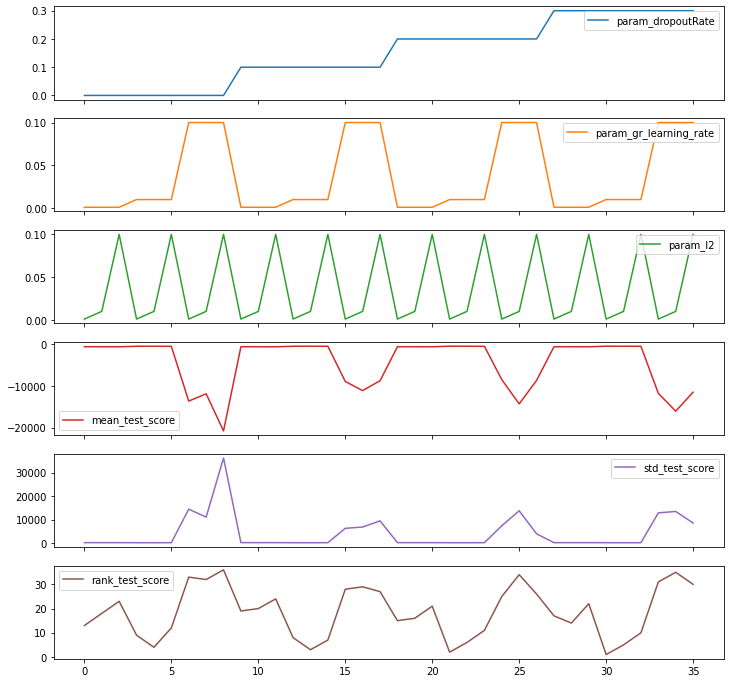

Results on GridSeachCV
Training: 
The best model score is : -440.12 
The best model parameters are: {'dropoutRate': 0.3, 'gr_learning_rate': 0.01, 'l2': 0.001} 


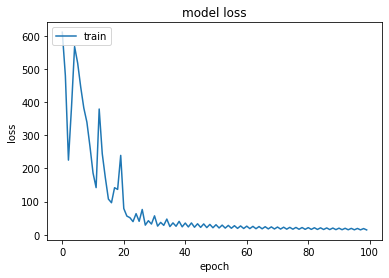

Results on Test Data
Model MSE on Test Data = 408.42
Model MAE on Test Data = 18.44
Model MAE_pct, on Test Data = 77.34%
CPU times: user 5min 14s, sys: 4.74 s, total: 5min 19s
Wall time: 5min 14s


In [18]:
%%time
model_grid_searchcv (model_1, param_grid, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

## Models 3
- Use tanh activation instead of relu

In [19]:
def model_3 (n = 1, activation = 'tanh', nodes = 13, loss = 'mse', optimizer = 'sgd', gr_learning_rate = 0.01, dropoutRate = 0 , l2 = 0.01): 
    model = keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 64, activation = activation, input_shape = (x_train_st.shape[1],),kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 64, activation= activation, kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 1 , activation="linear", kernel_regularizer = keras.regularizers.l2(l2)),
        ]
        , name="model_3",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate)  
    elif optimizer.lower() == 'rmsprop':
        optimizer=keras.optimizers.RMSprop(learning_rate=gr_learning_rate)   
    
    # Compile Model
    model.compile(optimizer= optimizer, 
                  loss= 'mean_squared_error', 
                  metrics= [tf.keras.metrics.MeanSquaredError()])
    
    return model

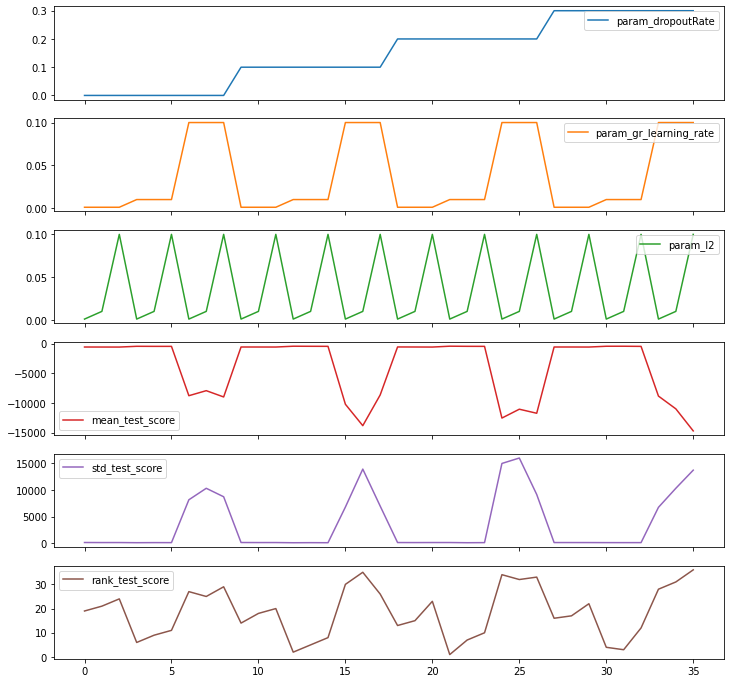

Results on GridSeachCV
Training: 
The best model score is : -435.34 
The best model parameters are: {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.001} 


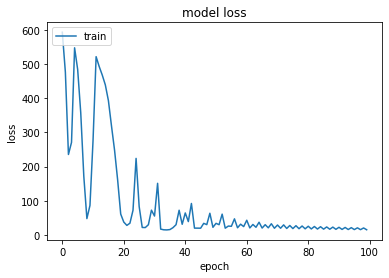

Results on Test Data
Model MSE on Test Data = 452.97
Model MAE on Test Data = 19.29
Model MAE_pct, on Test Data = 80.25%
CPU times: user 5min 15s, sys: 4.73 s, total: 5min 19s
Wall time: 5min 15s


In [20]:
%%time
model_grid_searchcv (model_1, param_grid, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

## Model 4 
- Use rmsprop optimizer

In [21]:
def model_4 (n = 1, activation = 'ReLU', nodes = 13, loss = 'mse', optimizer = 'rmsprop', gr_learning_rate = 0.01, dropoutRate = 0 , l2 = 0.01): 
    model = keras.models.Sequential([
    # create model
        keras.layers.Dense(units = 64, activation = activation, input_shape = (x_train_st.shape[1],),kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 64, activation= activation, kernel_regularizer = keras.regularizers.l2(l2)),
        keras.layers.Dropout(dropoutRate),
        keras.layers.Dense(units = 1 , activation="linear", kernel_regularizer = keras.regularizers.l2(l2)),
        ]
        , name="model_4",)
    
    # OPTIMIZER
    if optimizer.lower() == 'adam' :
        optimizer = keras.optimizers.Adam()
    elif optimizer.lower() == 'sgd' :
        optimizer=keras.optimizers.SGD(learning_rate=gr_learning_rate)  
    elif optimizer.lower() == 'rmsprop':
        optimizer=keras.optimizers.RMSprop(learning_rate=gr_learning_rate)
    
    # Compile Model
    model.compile(optimizer= optimizer, 
                  loss= 'mean_squared_error', 
                  metrics= [tf.keras.metrics.MeanSquaredError()])
    
    return model

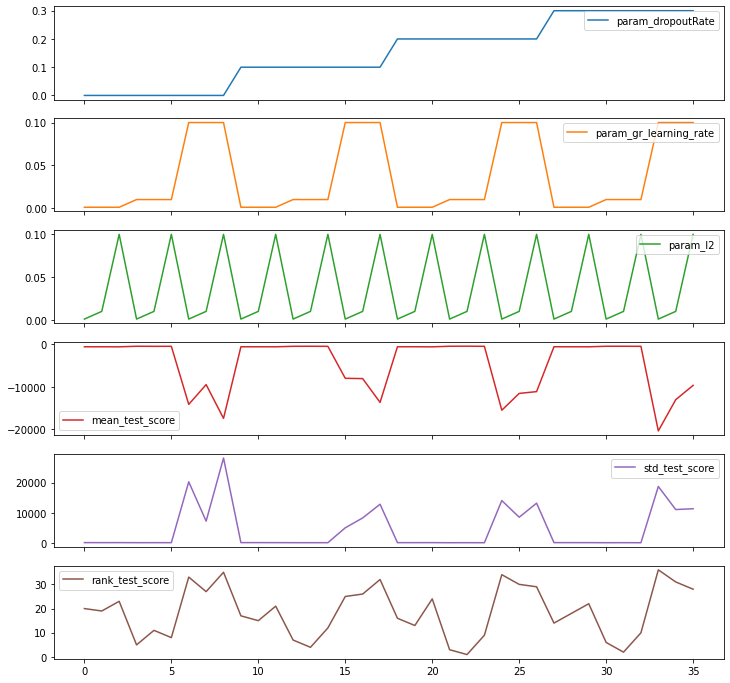

Results on GridSeachCV
Training: 
The best model score is : -437.29 
The best model parameters are: {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.01} 


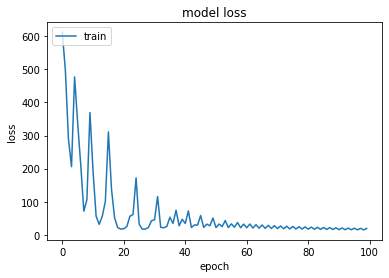

Results on Test Data
Model MSE on Test Data = 499.64
Model MAE on Test Data = 20.58
Model MAE_pct, on Test Data = 87.52%
CPU times: user 5min 14s, sys: 4.79 s, total: 5min 19s
Wall time: 5min 14s


In [22]:
%%time
model_grid_searchcv (model_1, param_grid, x_train_st, y_train, x_test_st, y_test, verbose = 0, kfold = 20)

## Provide a short and clear description of the results and interpretation of model summary results 
### Summary Table
As seen from the table below, model 2 gets the best results. The combination is a wide model with dropout ration of 0.3, learning rate of 0.01 and l2 regularization of 0.001. 

| Item |   Model| Training  Score|Test Evaluation, MAPE     | Best Parameters  |
| :--- |    :----:|:--- : |:----:| :---: | 
| 1    | Two Layer 64+64 + ReLU + SGD     | -448.18 |86.37%| {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.001} |
| 2    | Two Layer 128+64 + ReLU + SGD    | -440.12 |77.34%| {'dropoutRate': 0.3, 'gr_learning_rate': 0.01, 'l2': 0.001} |
| 3    | Two Layer 128+64 + tanh + SGD    | -435.34 |80.25%| {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.001} |
| 4    | Two Layer 128+64 + ReLU + rmsprop| -437.29 |87.52%| {'dropoutRate': 0.2, 'gr_learning_rate': 0.01, 'l2': 0.01}  |

### Hyper parameter tuning strategies
1. Deciding on the network topology, i.e. number of hidden layers, number of nodes in each layer
2. Optimizer Learning Rate - Too slow of a learning rate will not allow the error to converge while too fast learning rate would miss the local/global minima and lead to diverging errors.
3. Choosing an approrpiate optimizer - The usage of optimizer also results in varying results. 
4. Using the appropriate activation function for layers - ReLU is preferred compared to tanh.
5. dropout rate - number of neurons dropped during training.
6. regularization - prevents overfitting of weights at each layer.